<a href="https://colab.research.google.com/github/hhdjwdabsxsx/Hate-Speech-Detection-using-Deep-Learning/blob/main/Copy_of_Hate_Speech_Detection_using_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Hate Speech Detection using Deep Learning**

**Import Libraries and Dataset**

Python libraries make it very easy for us to handle the data and perform typical and complex tasks with a single line of code.



*   Pandas: This library helps to load the data frame in a 2D array format and has multiple functions to perform analysis tasks in one go.

*   NumPy: NumPy arrays are very fast and can perform large computations in a very short time.

*   Matplotlib/Seaborn/Wordcloud: This library is used to draw visualizations.

*   NLTK: Natural Language Tool Kit provides vatious functions to process the raw textual data.






In [ ]:
%%capture
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split

# Text Pre-processing libraries
import nltk
import string
import warnings
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

#Tensorflow imports to build the model
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
warnings.filterwarnings('ignore')


Now let's load the dataset into a pandas data frame and look at the first five rows of the dataset.

In [ ]:
df = pd.read_csv('hate_speech.csv')
df.head()

class                                              tweet
0      2  !!! RT @mayasolovely: As a woman you shouldn't...
1      1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2      1  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3      1  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4      1  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...

To check how many such tweets data we have let's print the shapw of the data frame.

In [ ]:
df.shape

(24783, 2)

Although there are only two columns in this dataset let's check the info about their columns.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   24783 non-null  int64 
 1   tweet   24783 non-null  object
dtypes: int64(1), object(1)
memory usage: 387.4+ KB


The shape of the data frame and the number of non-null values are the same hence we can stay that there are no null values in the dataset.

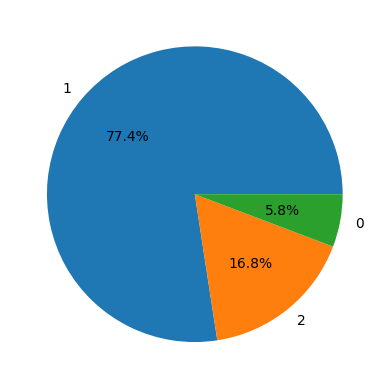

In [ ]:
plt.pie(df['class'].value_counts().values,
        labels = df['class'].value_counts().index,
        autopct='%1.1f%%')

plt.show()


**Text Preprocessing**

Textual data is highly unstructured and need attention on many aspects like:



*   Stopwords Removal
*   Punctuations Removal
*   Stemming or Lemmatization

Although removing data means loss of information but we need to do this to make the data perfect to feed into a machine learning model.





In [ ]:
# Lower case call the words of the tweet before any preprocessing
df['tweet'] = df['tweet'].str.lower()

# Removing punctuations present in the text
punctuations_list = string.punctuation
def remove_punctuations(text):
  temp = str.maketrans('', '', punctuations_list)
  return text.translate(temp)

df['tweet'] = df['tweet'].apply(lambda x: remove_punctuations(x))
df.head()


class                                              tweet
0      2   rt mayasolovely as a woman you shouldnt compl...
1      1   rt mleew17 boy dats coldtyga dwn bad for cuff...
2      1   rt urkindofbrand dawg rt 80sbaby4life you eve...
3      1     rt cganderson vivabased she look like a tranny
4      1   rt shenikaroberts the shit you hear about me ...

The below function is a helper function that will help us to remove the stop words and Lemmatize the important words.

In [ ]:
def remove_stopwards(text):
  stop_words = stopwords.words('english')

  imp_words = []

  # Storing the important words
  for word in str(text).split():

    if word not in stop_words:

      # Let's Lemmatize the word as well
      # before appending to the imp_words list.

      lemmatizer = WordNetLemmatizer()
      lemmatizer.lemmatize(word)

      imp_words.append(word)

  output = " ".join(imp_words)

  return output

df['tweet'] = df['tweet'].apply(lambda text: remove_stopwards(text))
df.head()

class                                              tweet
0      2  rt mayasolovely woman shouldnt complain cleani...
1      1  rt mleew17 boy dats coldtyga dwn bad cuffin da...
2      1  rt urkindofbrand dawg rt 80sbaby4life ever fuc...
3      1           rt cganderson vivabased look like tranny
4      1  rt shenikaroberts shit hear might true might f...

Word cloud is a text visualization tool that helps us to get insights into the most frequent words present in the corpus of the data.

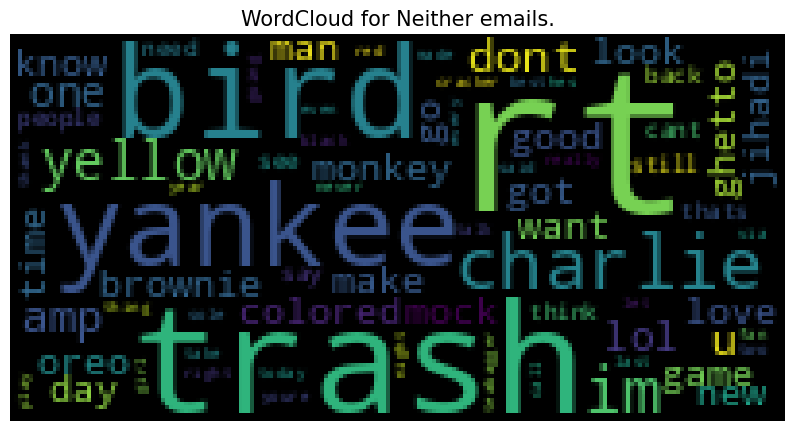

In [ ]:
def plot_word_cloud(data, typ):
  # Joining all the tweets to get the corpus
  email_corpus = " ".join(data['tweet'])

  plt.figure(figsize = (10,10))

  # Forming the word cloud
  wc = WordCloud(max_words = 100,
                 width = 200,
                 height = 100,
                 collocations = False).generate(email_corpus)

  # Plotting the wordcloud obtained above
  plt.title(f'WordCloud for {typ} emails.', fontsize = 15)
  plt.axis('off')
  plt.imshow(wc)
  plt.show()
  print()

plot_word_cloud(df[df['class']==2], typ='Neither')

As we know from above taht the data we has was highly imbalanced. Now we will solve this problem by using a mixture of down sampling and up sampling.

In [ ]:
class_2 = df[df['class'] == 2]
class_1 = df[df['class'] == 1].sample(n=3500)
class_0 = df[df['class'] == 0]

balanced_df = pd.concat([class_0, class_0, class_0, class_1, class_2], axis = 0)

Now let's check what is the data distribution in the three classes.

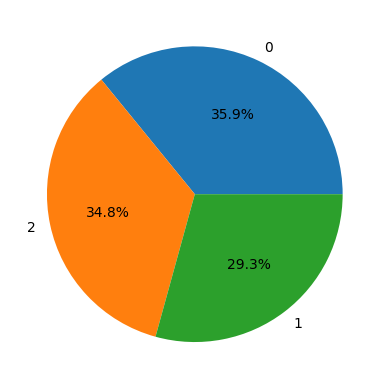

In [ ]:
plt.pie(balanced_df['class'].value_counts().values,
        labels=balanced_df['class'].value_counts().index,
        autopct='%1.1f%%') # Changed the autopct format specifier to remove the comma
plt.show()

After this step we can be sure of the fact that the data is perfectly balanced for the three classes.

**Word2Vec Conversion**

We cannot feed words to a machine learning model because they work on numbers only. So first, we will convert our words to vectors with the token id's to the corresponding words and after padding them our textual data will arrive to a stage where we can feed it to a model.

In [ ]:
features = balanced_df['tweet']
target = balanced_df['class']

X_train, X_val, Y_train, Y_val = train_test_split(features,
                                                  target,
                                                  test_size=0.2,
                                                  random_state=22)
X_train.shape, X_val.shape

((9562,), (2391,))

We have successfully divided our data into training and validation data.

In [ ]:
Y_train = pd.get_dummies(Y_train)
Y_val = pd.get_dummies(Y_val)
Y_train.shape, Y_val.shape

((9562, 3), (2391, 3))

The labels of the classes have been converted into one-hot-encoded vectors. For this, we will use a vocabulary size of 5000 with each tweet not more than 100 in length.

In [ ]:
max_words = 5000
max_len = 100

token = Tokenizer(num_words=max_words,
                  lower=True,
                  split=' ')

token.fit_on_texts(X_train)

We have fitted the tokenizer on our training data. We will use it to convert the training and validation data both to vectors.

In [ ]:
# training the tokenizer
max_words = 5000
token = Tokenizer(num_words=max_words,
                  lower=True,
                  split=' ')
token.fit_on_texts(X_train)

# Generating token embeddings
Training_seq = token.texts_to_sequences(X_train)
Training_pad = pad_sequences(Training_seq,
                            maxlen=50,
                            padding='post',
                            truncating='post')

Testing_seq = token.texts_to_sequences(X_val)
Testing_pad = pad_sequences(Testing_seq,
                            maxlen=50,
                            padding='post',
                            truncating='post')

**Model Development and Evaluation**

We will implement a Sequential model which will contain the following parts:



*   Three Embedding Layers to learn a featured vector representations of the input vectors.

*   A Bidirectionsl LSTM layer to identify useful patterns in the sequence.

*   Then we will have one fully connected layer.

*   We have included some BatchNormalization layers to enable stable and fast training and a Droput lsyer before the final layer to avoid any possibility of overfitting.



*   The final layer is the output lsyer which gives output of soft probabilities for the three classes.








In [ ]:
model = keras.models.Sequential([
	layers.Embedding(max_words, 32, input_length=max_len),
	layers.Bidirectional(layers.LSTM(16)),
	layers.Dense(512, activation='relu', kernel_regularizer='l1'),
	layers.BatchNormalization(),
	layers.Dropout(0.3),
	layers.Dense(3, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
			optimizer='adam',
			metrics=['accuracy'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

While compiling a model we provide these three essentail parameters:



*   optimizer: This is the method that jelps to optimize the cost function by  using gradient descent.

*   loss: The loss function by which we monitor whether the model is imrpoving with training or not.

*   metrics: This helps to evaluate the model by predicting the training and the
validation data.






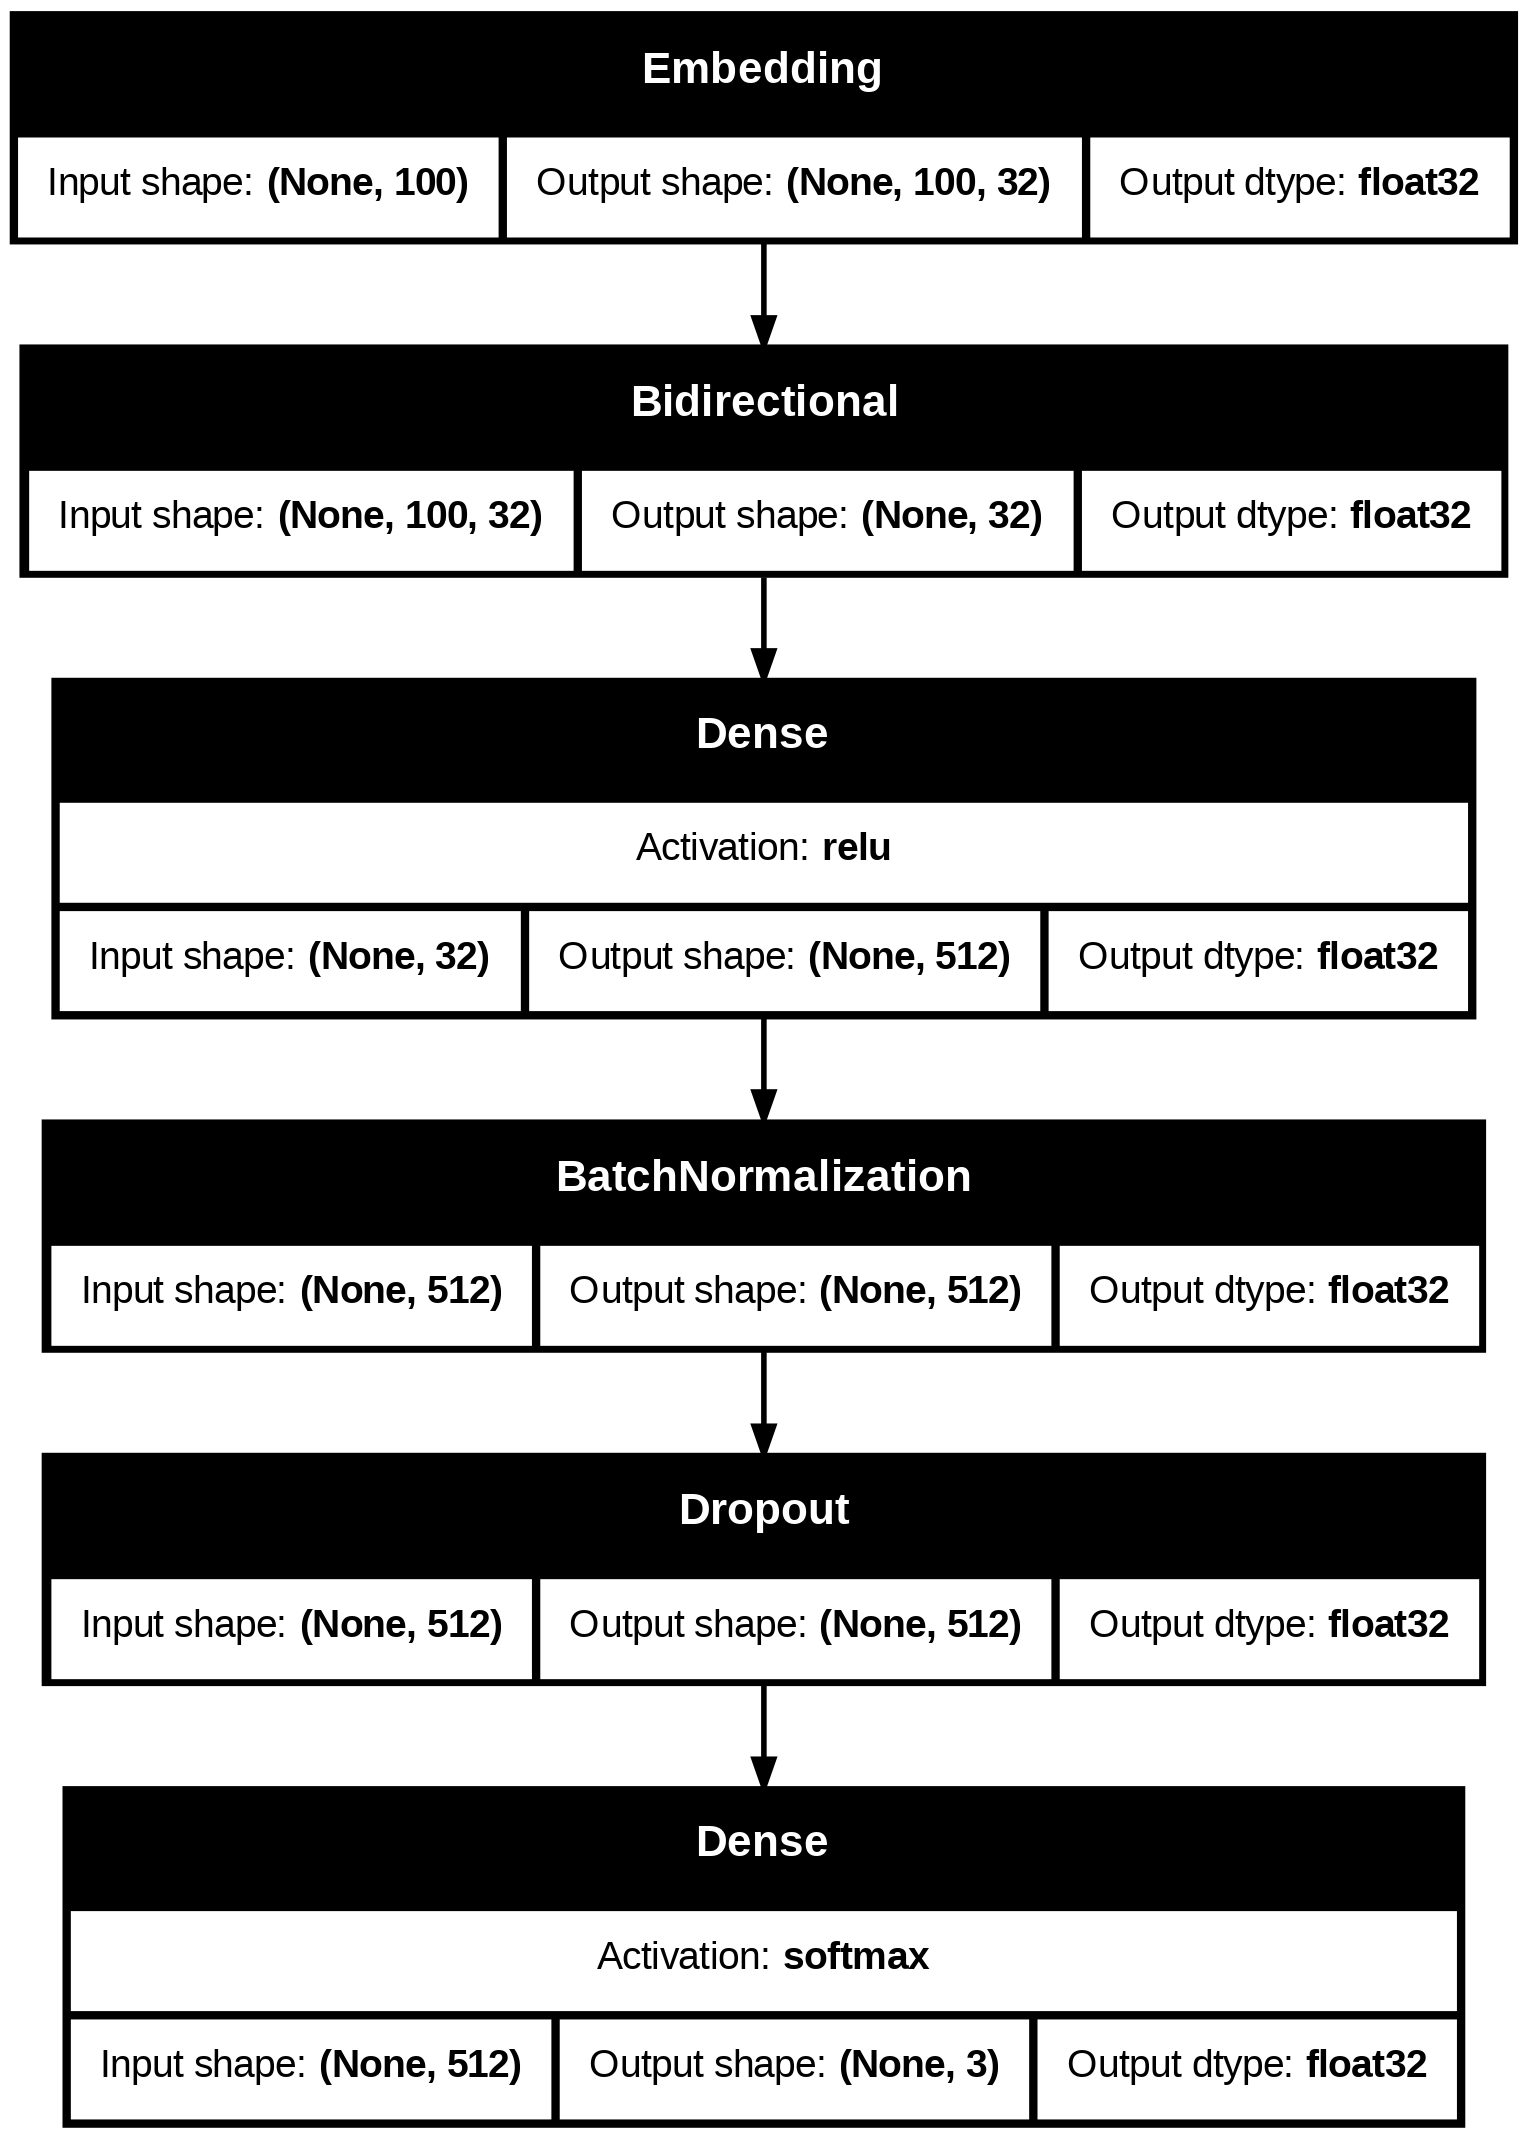

In [ ]:
# Add a dummy input to build the model
model.build((None, max_len))

keras.utils.plot_model(
    model,
    show_shapes=True,
    show_dtype=True,
    show_layer_activations=True
)

**Call Back**

Callbacks are used to check whether the model is improving with each epoch or not. If not then what are necessary steps to be taken like ReduceLROnPlateau decreases learning rate further. Even then if model performance is not improving then training will be stopped by EarlyStopping. We caan also define some custom callbacks to sstop training in between if the desired results have been obtained early.

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

es = EarlyStopping(patience=3,
                   monitor = 'val_accuracy',
                   restore_best_weights = True)

lr = ReduceLROnPlateau(patience = 2,
                       monitor = 'val_loss',
                       factor = 0.5,
                       verbose = 0)

So finally, we have reached the step when we will train our model.

In [ ]:
# Instantiate Tokenizer
tokenizer = Tokenizer(num_words=max_words)

# Fit on the training data
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

# Pad sequences for uniform length
from tensorflow.keras.utils import pad_sequences
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len)
X_val_padded = pad_sequences(X_val_seq, maxlen=max_len)

# Now use X_train_padded and X_val_padded in your model.fit()
history = model.fit(X_train_padded, Y_train,
                    validation_data=(X_val_padded, Y_val),
                    epochs=50,
                    verbose=1,
                    batch_size=32,
                    callbacks=[lr, es])

Epoch 1/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 23s 76ms/step - accuracy: 0.9881 - loss: 0.0620 - val_accuracy: 0.8900 - val_loss: 0.4883 - learning_rate: 3.1250e-05
Epoch 2/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 43s 82ms/step - accuracy: 0.9872 - loss: 0.0630 - val_accuracy: 0.8917 - val_loss: 0.4861 - learning_rate: 3.1250e-05
Epoch 3/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 41s 82ms/step - accuracy: 0.9891 - loss: 0.0606 - val_accuracy: 0.8975 - val_loss: 0.4758 - learning_rate: 3.1250e-05


To get a better picture of the training progress we should plot the graph of loss and accuracy epoch-by-epoch

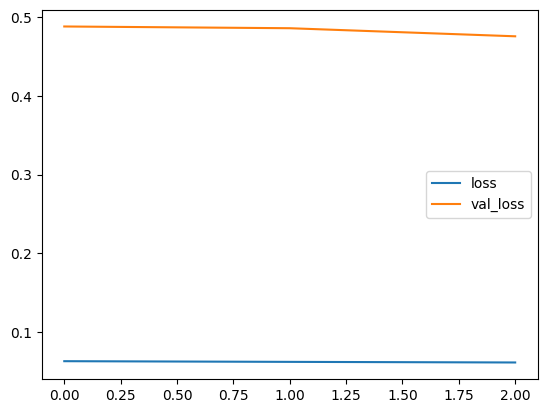

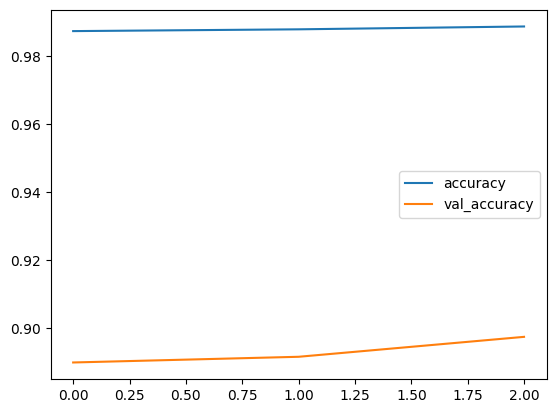

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
plt.show()

**Conclusion**

The model we have trained is a little over fitting the training dta but we can handle this by different regularization techniques. But still, we have achieved 90% accyuracy on the validation data which is quite sufficient to peove the power of LSTM models in NLP-related tasks.